## Processing sensor data from Shale Hills CZO NPMS site ##

Marc Berghouse 8/8/2020

This array includes:
- Apogee Instruments SO-110 O2 sensors
- Eosense EosGP CO2 sensors

## Check temp sensor drift calculations in cell 7. I'm not sure if it makes sense to use this or just drop the data for that time period ##


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt



# Define filenames
infile1 = "../../raw_data/Shale Hills/NPMS/NPMS_CO2_O2.csv" 
infile2 = "../../raw_data/Shale Hills/NPMS/ShaleHills_precipitation.csv" 


# Read the .dat files as Pandas dataframes and load in the date/times
df1 = pd.read_csv(infile1,  na_values=['NAN', -9999, -99999], parse_dates=[0], index_col=0) 
df2 = pd.read_csv(infile2, na_values=['NAN', -9999, -99999], parse_dates=[0], index_col=0) 



In [2]:
#merge dataframes and drop record columns
df=pd.concat([df1,df2], sort=False)
df=df.drop(columns="RecNum")
df=df.drop(columns='Correlation')
df=df.drop(columns='Comment')
df

,DiffVolt_1,DiffVolt_2,O2_20,O2_D_20,T109_1_C,T109_2_C,CO2_20_lo,CO2_20_hi,CO2_20_temp,CO2_D_20_lo,CO2_D_20_hi,CO2_D_20_temp,Total_Precip_mm,Device
TmStamp,,,,,,,,,,,,,,
2016-08-16 12:00:00,52.599998,47.560001,20.690001,20.440001,-273.20001,-105.4,5050.2031,2985.0740,24.200001,5009.4980,40075.980,25.700001,NaN,NaN
2016-08-16 13:00:00,52.389999,47.560001,20.610001,20.440001,-273.20001,-105.4,5044.7749,2957.9370,24.010000,5013.5679,40097.680,25.629999,NaN,NaN
2016-08-16 14:00:00,52.389999,47.560001,20.610001,20.440001,-273.20001,-105.4,5048.8838,2887.4031,23.860001,5006.8208,40054.570,25.740000,NaN,NaN
2016-08-16 15:00:00,52.320000,47.590000,20.580000,20.459999,-273.20001,-105.4,5045.0688,2854.9829,24.110001,5009.7900,40067.461,25.709999,NaN,NaN
2016-08-16 16:00:00,52.320000,47.560001,20.580000,20.440001,-273.20001,-105.4,5048.8481,2795.1160,24.219999,5008.1421,40054.289,26.139999,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,OTT Pluvio392
2018-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,OTT Pluvio393
2018-12-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.7,OTT Pluvio394


In [3]:
#Rename all columns with format "var_depth.unit" (SoilTemp_102cm.deg.C)

df.columns=["DiffVolt_20cm.mV", "DiffVolt_140cm.mV", "O2_20cm.percent.0-100", "O2_140cm.percent.0-100",  "ApogeeTemp_20cm.deg.C" , "ApogeeTemp_140cm.deg.C", "CO2lo_20cm.ppm","CO2hi_20cm.ppm", "GPTemp_20cm.deg.C", "CO2lo_140cm.ppm", "CO2hi_140cm.ppm", "GPTemp_140cm.deg.C","Precipitation.mm", "Device"]
df=df.drop(columns='Device')
df

,DiffVolt_20cm.mV,DiffVolt_140cm.mV,O2_20cm.percent.0-100,O2_140cm.percent.0-100,ApogeeTemp_20cm.deg.C,ApogeeTemp_140cm.deg.C,CO2lo_20cm.ppm,CO2hi_20cm.ppm,GPTemp_20cm.deg.C,CO2lo_140cm.ppm,CO2hi_140cm.ppm,GPTemp_140cm.deg.C,Precipitation.mm
TmStamp,,,,,,,,,,,,,
2016-08-16 12:00:00,52.599998,47.560001,20.690001,20.440001,-273.20001,-105.4,5050.2031,2985.0740,24.200001,5009.4980,40075.980,25.700001,NaN
2016-08-16 13:00:00,52.389999,47.560001,20.610001,20.440001,-273.20001,-105.4,5044.7749,2957.9370,24.010000,5013.5679,40097.680,25.629999,NaN
2016-08-16 14:00:00,52.389999,47.560001,20.610001,20.440001,-273.20001,-105.4,5048.8838,2887.4031,23.860001,5006.8208,40054.570,25.740000,NaN
2016-08-16 15:00:00,52.320000,47.590000,20.580000,20.459999,-273.20001,-105.4,5045.0688,2854.9829,24.110001,5009.7900,40067.461,25.709999,NaN
2016-08-16 16:00:00,52.320000,47.560001,20.580000,20.440001,-273.20001,-105.4,5048.8481,2795.1160,24.219999,5008.1421,40054.289,26.139999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2018-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2018-12-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.7


In [4]:
#masking values that seem erroneous

df.loc['2018-6-20':]=np.nan
df.mask(df<=-0.01, inplace=True)

df

,DiffVolt_20cm.mV,DiffVolt_140cm.mV,O2_20cm.percent.0-100,O2_140cm.percent.0-100,ApogeeTemp_20cm.deg.C,ApogeeTemp_140cm.deg.C,CO2lo_20cm.ppm,CO2hi_20cm.ppm,GPTemp_20cm.deg.C,CO2lo_140cm.ppm,CO2hi_140cm.ppm,GPTemp_140cm.deg.C,Precipitation.mm
TmStamp,,,,,,,,,,,,,
2016-08-16 12:00:00,52.599998,47.560001,20.690001,20.440001,NaN,NaN,5050.2031,2985.0740,24.200001,5009.4980,40075.980,25.700001,NaN
2016-08-16 13:00:00,52.389999,47.560001,20.610001,20.440001,NaN,NaN,5044.7749,2957.9370,24.010000,5013.5679,40097.680,25.629999,NaN
2016-08-16 14:00:00,52.389999,47.560001,20.610001,20.440001,NaN,NaN,5048.8838,2887.4031,23.860001,5006.8208,40054.570,25.740000,NaN
2016-08-16 15:00:00,52.320000,47.590000,20.580000,20.459999,NaN,NaN,5045.0688,2854.9829,24.110001,5009.7900,40067.461,25.709999,NaN
2016-08-16 16:00:00,52.320000,47.560001,20.580000,20.440001,NaN,NaN,5048.8481,2795.1160,24.219999,5008.1421,40054.289,26.139999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


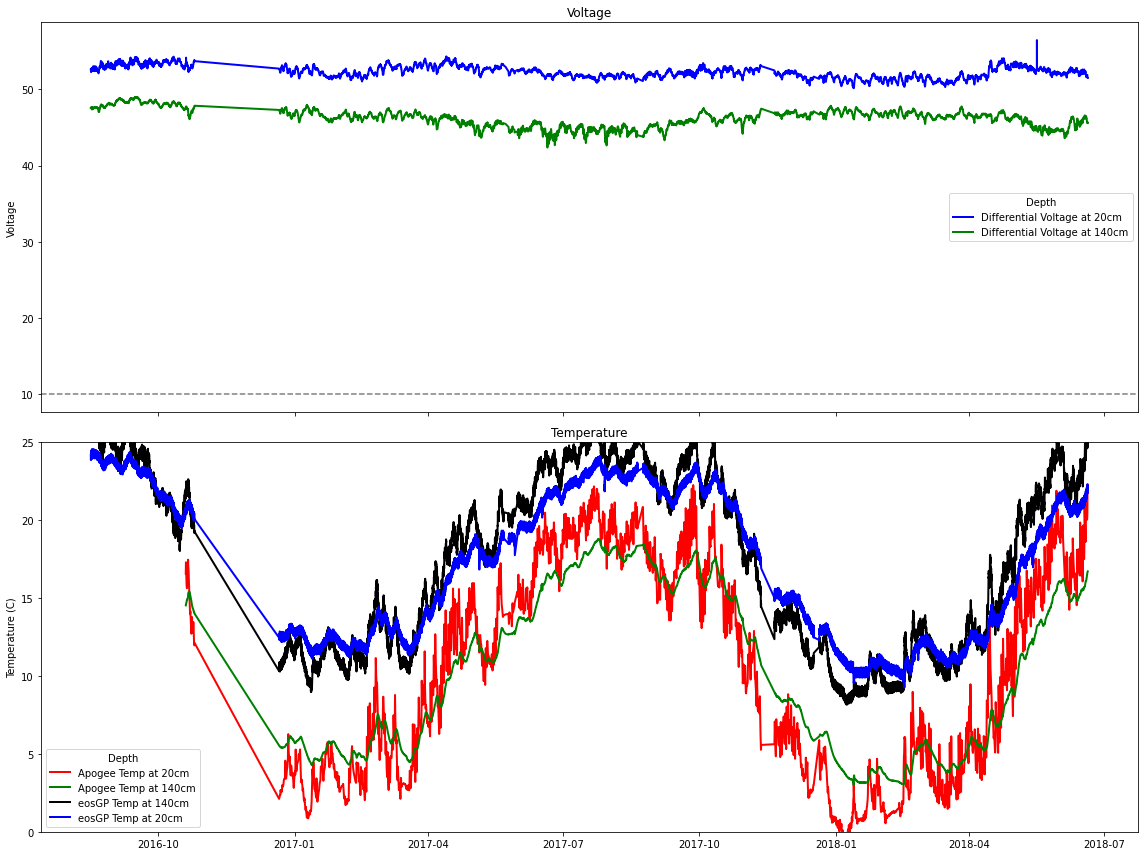

In [5]:
# Plot the datalogger parameters: battery voltage, panel temperature, enclosure temperature, and barometric pressure
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,12), tight_layout=True)

# Apogee SO-110 differntial voltages
ax1.plot(df.index, df['DiffVolt_20cm.mV'], 'b', linewidth=2, label='Differential Voltage at 20cm')
ax1.plot(df.index, df['DiffVolt_140cm.mV'], 'g', linewidth=2, label='Differential Voltage at 140cm')
ax1.set(ylabel='Voltage', title='Voltage')#, ylim=[36,48])
ax1.axhline(y=10, linestyle='--', color='k', alpha=0.5)
ax1.legend(title='Depth', loc='best')

# datalogger temperatures

ax2.plot(df.index, df["ApogeeTemp_20cm.deg.C"], 'r', linewidth=2, label='Apogee Temp at 20cm')
ax2.plot(df.index, df["ApogeeTemp_140cm.deg.C"], 'g', linewidth=2, label='Apogee Temp at 140cm')
ax2.plot(df.index, df['GPTemp_140cm.deg.C'], 'k', linewidth=2, label='eosGP Temp at 140cm')
ax2.plot(df.index, df['GPTemp_20cm.deg.C'], 'b', linewidth=2, label='eosGP Temp at 20cm')
ax2.set(ylabel='Temperature (C)', title='Temperature', ylim=[0,25])
ax2.legend(title='Depth', loc='best')


In [6]:
#Drop unnecessary data 
#I calculated the drift between the two temperature sensors, but I'm not if it is an accurate method to extrapolate temperatures from eosGP
df=df.drop(columns='DiffVolt_140cm.mV')
df=df.drop(columns='DiffVolt_20cm.mV')
#df=df.drop(columns='GPTemp_20cm.deg.C')
#df=df.drop(columns='GPTemp_140cm.deg.C')
df['ApogeeTemp_20cm_avg']=np.mean(df['ApogeeTemp_20cm.deg.C'])
df['ApogeeTemp_140cm_avg']=np.mean(df['ApogeeTemp_140cm.deg.C'])
df['GPTemp_20cm_avg']=np.mean(df['GPTemp_20cm.deg.C'])
df['GPTemp_140cm_avg']=np.mean(df['GPTemp_140cm.deg.C'])
df['ApogeeDrift_20cm']=df['ApogeeTemp_20cm_avg']-df['GPTemp_20cm_avg']
df['ApogeeDrift_140cm']=df['ApogeeTemp_140cm_avg']-df['GPTemp_140cm_avg']
df

,O2_20cm.percent.0-100,O2_140cm.percent.0-100,ApogeeTemp_20cm.deg.C,ApogeeTemp_140cm.deg.C,CO2lo_20cm.ppm,CO2hi_20cm.ppm,GPTemp_20cm.deg.C,CO2lo_140cm.ppm,CO2hi_140cm.ppm,GPTemp_140cm.deg.C,Precipitation.mm,ApogeeTemp_20cm_avg,ApogeeTemp_140cm_avg,GPTemp_20cm_avg,GPTemp_140cm_avg,ApogeeDrift_20cm,ApogeeDrift_140cm
TmStamp,,,,,,,,,,,,,,,,,
2016-08-16 12:00:00,20.690001,20.440001,NaN,NaN,5050.2031,2985.0740,24.200001,5009.4980,40075.980,25.700001,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783
2016-08-16 13:00:00,20.610001,20.440001,NaN,NaN,5044.7749,2957.9370,24.010000,5013.5679,40097.680,25.629999,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783
2016-08-16 14:00:00,20.610001,20.440001,NaN,NaN,5048.8838,2887.4031,23.860001,5006.8208,40054.570,25.740000,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783
2016-08-16 15:00:00,20.580000,20.459999,NaN,NaN,5045.0688,2854.9829,24.110001,5009.7900,40067.461,25.709999,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783
2016-08-16 16:00:00,20.580000,20.440001,NaN,NaN,5048.8481,2795.1160,24.219999,5008.1421,40054.289,26.139999,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783
2018-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783
2018-12-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783


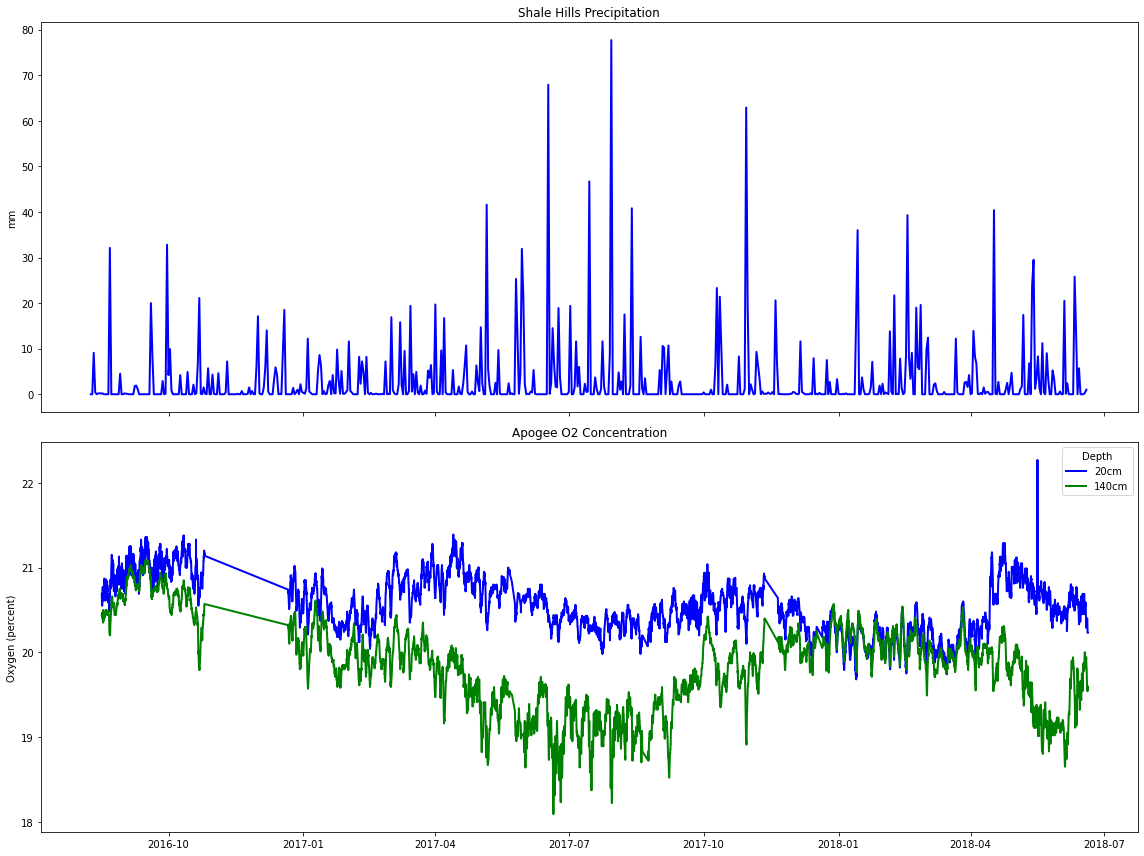

In [7]:
df.loc['2006-1-1':'2016-8-8']=np.nan


fig, (ax1, ax2) = plt.subplots(2, figsize=(16,12), sharex=True, tight_layout=True)
ax1.plot(df.index, df['Precipitation.mm'], 'b', linewidth=2)
ax1.set(ylabel='mm', title='Shale Hills Precipitation')

ax2.plot(df.index, df['O2_20cm.percent.0-100'], 'b', linewidth=2, label='20cm')
ax2.set(ylabel='Oxygen (percent)', title='Apogee O2 Concentration')
ax2.plot(df.index, df['O2_140cm.percent.0-100'], 'g', linewidth=2, label='140cm')
ax2.legend(title='Depth', loc='best')

#df['Apogee_CorrO2_Avg'] = df['SoilO2_30cm.kPa']/df['BarometricPress_Avg']*100
#ax3.plot(df.index, df['Apogee_CorrO2_Avg'], 'k', linewidth=2)
#ax3.set(ylabel='Oxygen (%)', title='Apogee O2 Concentration');

In [8]:
#Combine CO2lo and CO2hi
#df['CO2_30cm.ppm'] = np.nan

mask = df['CO2lo_20cm.ppm'] < 5000
df.loc[mask, 'CO2_20cm.ppm'] = df.loc[mask, 'CO2lo_20cm.ppm']
df.loc[~mask, 'CO2_20cm.ppm'] = df.loc[~mask, 'CO2hi_20cm.ppm']
mask2 = df['CO2lo_140cm.ppm'] < 5000
df.loc[mask2, 'CO2_140cm.ppm'] = df.loc[mask2, 'CO2lo_140cm.ppm']
df.loc[~mask2, 'CO2_140cm.ppm'] = df.loc[~mask2, 'CO2hi_140cm.ppm']

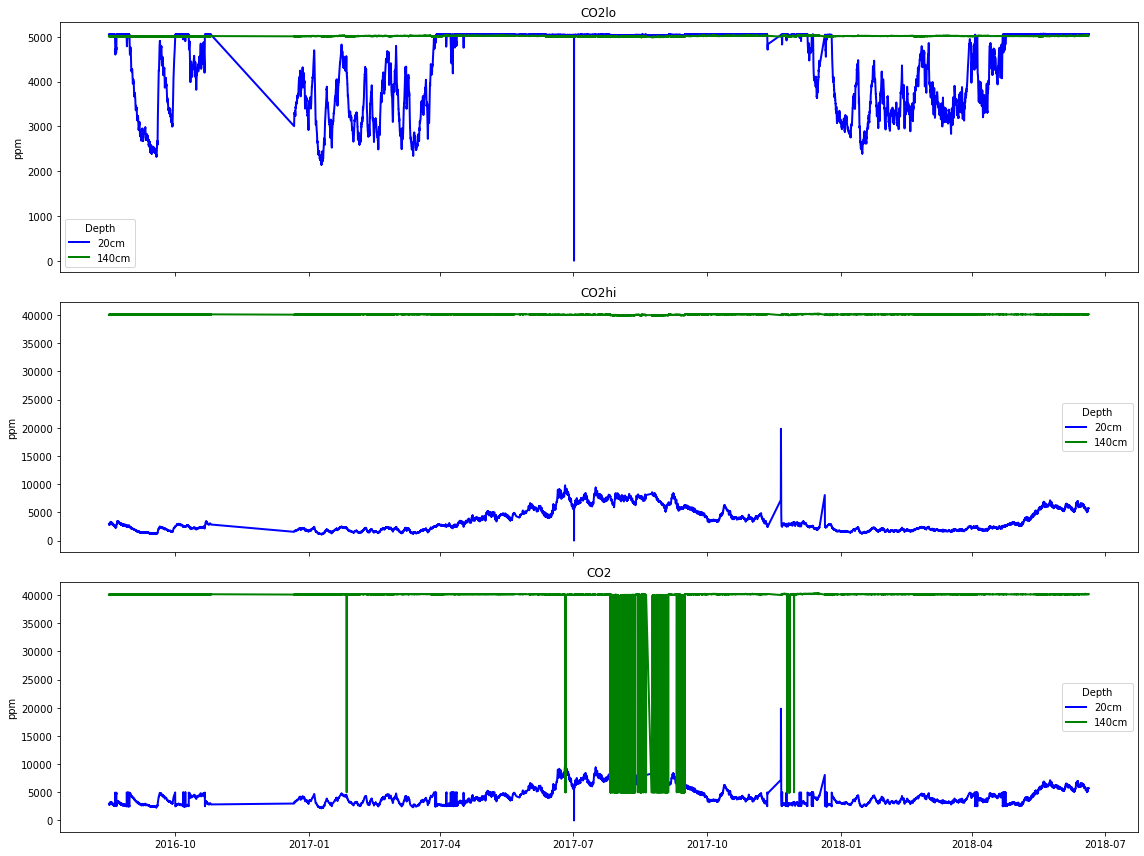

In [9]:
#Plot CO2 data 
#keeping this CO2 percentage mask here just in case it is helpful in the future. Right now, I can think of no use for it
#df['pct_change_CO2lo30']=(df['CO2lo_30cm.ppm'].pct_change())
#df['CO2lo_30cm.ppm'].mask(df['pct_change_CO2lo30']>=.5, inplace=True)
#df['CO2lo_30cm.ppm'].mask(df['pct_change_CO2lo30']<=-.5, inplace=True)


fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,12), sharex=True, tight_layout=True)
ax1.plot(df.index, df['CO2lo_20cm.ppm'], 'b', linewidth=2, label='20cm')
ax1.plot(df.index, df['CO2lo_140cm.ppm'], 'g', linewidth=2, label='140cm')
ax1.set(ylabel='ppm', title='CO2lo')
ax1.legend(title='Depth', loc='best')
ax2.plot(df.index, df['CO2hi_20cm.ppm'], 'b', linewidth=2, label='20cm')
ax2.plot(df.index, df['CO2hi_140cm.ppm'], 'g', linewidth=2, label='140cm')
ax2.set(ylabel='ppm', title='CO2hi')
ax2.legend(title='Depth', loc='best')
ax3.plot(df.index, df['CO2_20cm.ppm'], 'b', linewidth=2, label='20cm')
ax3.plot(df.index, df['CO2_140cm.ppm'], 'g', linewidth=2, label='140cm')
ax3.set(ylabel='ppm', title='CO2')
ax3.legend(title='Depth', loc='best')

In [10]:
#Drop bad and extraneous CO2 data 
df=df.drop(columns='CO2lo_140cm.ppm')
df=df.drop(columns='CO2hi_140cm.ppm')
df=df.drop(columns='CO2lo_20cm.ppm')
df=df.drop(columns='CO2hi_20cm.ppm')
df=df.drop(columns='CO2_140cm.ppm')

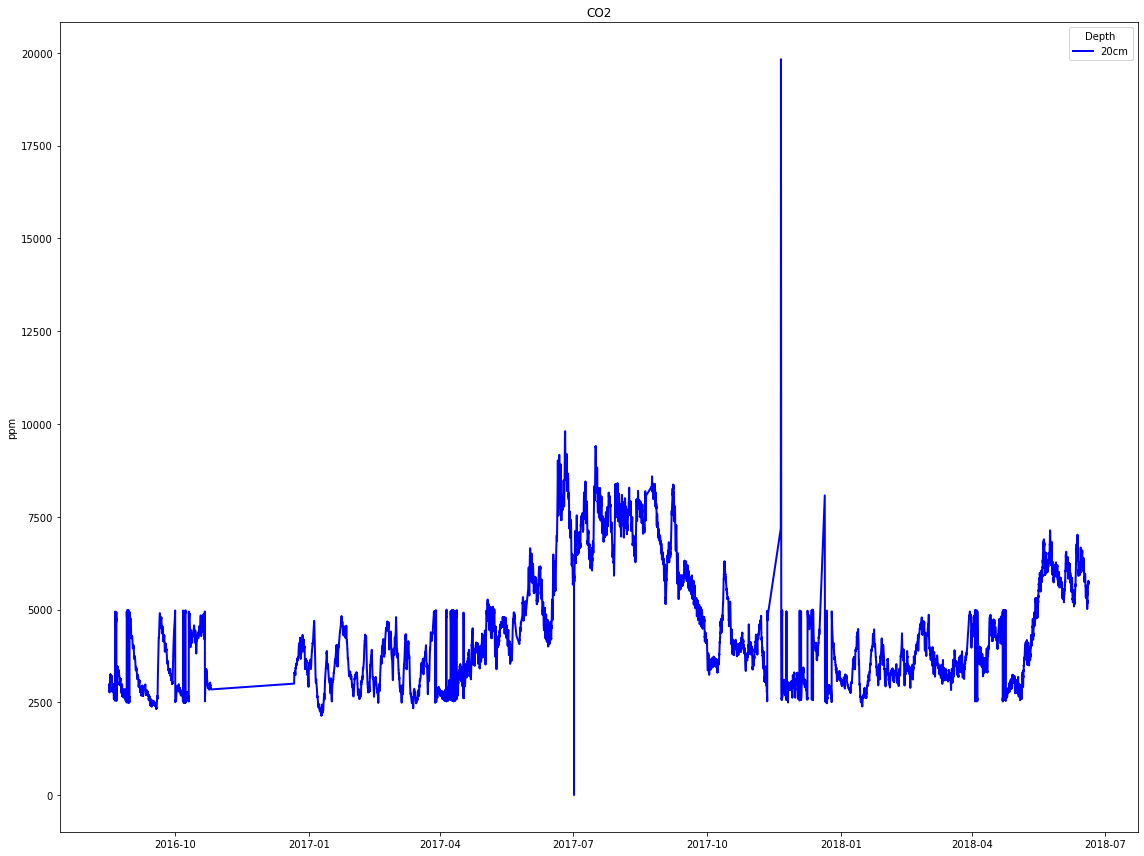

In [11]:
#Check final CO2 output
fig, (ax1) = plt.subplots(1, figsize=(16,12), sharex=True, tight_layout=True)
ax1.plot(df.index, df['CO2_20cm.ppm'], 'b', linewidth=2, label='20cm')
#ax1.plot(df.index, df['CO2_140cm.ppm'], 'g', linewidth=2, label='140cm')
ax1.set(ylabel='ppm', title='CO2')
ax1.legend(title='Depth', loc='best')

In [12]:
output=df.copy()
today = dt.date.today()
outfile = '../../processed_data/Shale Hills/NPMS_CO2_O2_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [13]:
output

,O2_20cm.percent.0-100,O2_140cm.percent.0-100,ApogeeTemp_20cm.deg.C,ApogeeTemp_140cm.deg.C,GPTemp_20cm.deg.C,GPTemp_140cm.deg.C,Precipitation.mm,ApogeeTemp_20cm_avg,ApogeeTemp_140cm_avg,GPTemp_20cm_avg,GPTemp_140cm_avg,ApogeeDrift_20cm,ApogeeDrift_140cm,CO2_20cm.ppm
TmStamp,,,,,,,,,,,,,,
2016-08-16 12:00:00,20.690001,20.440001,NaN,NaN,24.200001,25.700001,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783,2985.0740
2016-08-16 13:00:00,20.610001,20.440001,NaN,NaN,24.010000,25.629999,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783,2957.9370
2016-08-16 14:00:00,20.610001,20.440001,NaN,NaN,23.860001,25.740000,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783,2887.4031
2016-08-16 15:00:00,20.580000,20.459999,NaN,NaN,24.110001,25.709999,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783,2854.9829
2016-08-16 16:00:00,20.580000,20.440001,NaN,NaN,24.219999,26.139999,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783,2795.1160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783,NaN
2018-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783,NaN
2018-12-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.881507,10.133898,17.100039,17.518681,-1.218531,-7.384783,NaN
